# Determining What to Run Baseline Correction On

We need baseline corrections for all (good) entries in [this spreadsheet](https://onedrive.live.com/edit.aspx?resid=C3502B019E9CF5B9!323&ithint=file%2cxlsx&wdo=2&authkey=!AAb9dbohL6SwGeM); the goal is to determine which of these can share baseline corrections.

In [1]:
#Imports
import glob
import numpy as np
import pandas as pd
import lmfit as lf
import statistics as s
import matplotlib.pyplot as plt
from scipy import signal as sig
from R76Tools import *
#Settings
plt.style.use('./default.mplstyle')
datapath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"

## Keeping across different voltages

In this section, we will check whether the same baseline correction can be applied to the full dataset originally included in `Hv1_Calibration.ipynb`.

In [2]:
#Start by importing and organizing our data
ser = ["07220822_1828","07220826_1219","07220826_1536","07220826_2007","07220827_1153","07220830_1724"]#["07220702_0911"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"] #["data"]

e=[]; z=[];
for series in ser:
    filelist = glob.glob(datapath+series+"/umn*.root")
    e_chain,z_chain = makechain(filelist,fittingfilters)
    e.append(e_chain);z.append(z_chain)

for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)

In [3]:
#Now we do the linear fit on the last dataset, as before
points = [[0,149],[1200,96]]; 
m = (points[1][1]-points[0][1])/(points[1][0]-points[0][0]); b = points[0][1]

def line(x,m=m,b=b): return m*x+b #Define the equation of a line for fitting.

#Define our data points with our new y > 50 fit
x = z[4]['PSUMbs'][~z[4]['crand'] & z[4]['cphi1'] & z[4]['cam'] & (z[4]['pt_keV']>50)]-18000
y = z[4]['pt_keV'][~z[4]['crand'] & z[4]['cphi1'] & z[4]['cam'] & (z[4]['pt_keV']>50)]

#Set up to fit
mod = lf.Model(line); params = mod.make_params()
params.add('m',value=-0.2,max=0,min=-1);params.add('b',value=150,min=0) #give reasonable constraints
fit = mod.fit(y,params,x=x)
#fit #we've seen this before

In [4]:
#Then the Gaussian fit
bins = np.linspace(fit.best_values['b'],fit.best_values['b']+30,30)
h = np.histogram(y[(x<50) & (x>-50)],bins=bins); hy = h[0]; hx = h[1] #Get hist values from the plot
hx = (hx[:-1]+hx[1:])/2

#Find the peaks
peaks, _ = sig.find_peaks(hy,height=np.mean(hy)+1) #Don't detect peaks beneath mean value
#Set up and fit a gaussian near the median of all peaks. Scaled because hy is not normalized.
def gaussian(x,mu,sigma,A): return A*(2*np.pi)**(-1/2)/sigma*np.exp(-(x-mu)**2/(2*sigma**2))
modg = lf.Model(gaussian); paramsg = modg.make_params()
med = s.median(hx[peaks])
paramsg.add('mu',value=med,min=fit.best_values['b'],max=max(hx[peaks]))
paramsg.add('sigma',value=5,min=0)
paramsg.add('A',value=1,min=0,vary=False)
dist = hx[peaks][math.floor(len(peaks)/2)+1] - hx[peaks][math.floor(len(peaks)/2)] #get diff between medianish
rangemin = med-3*dist; rangemax = med+3*dist
rangeslice = (hx>=rangemin) & (hx<rangemax)
hyscaled = hy[rangeslice]/sum(hy[rangeslice])/(hx[1]-hx[0])
fitg = modg.fit(hyscaled,params=paramsg,x=hx[rangeslice])
#fitg

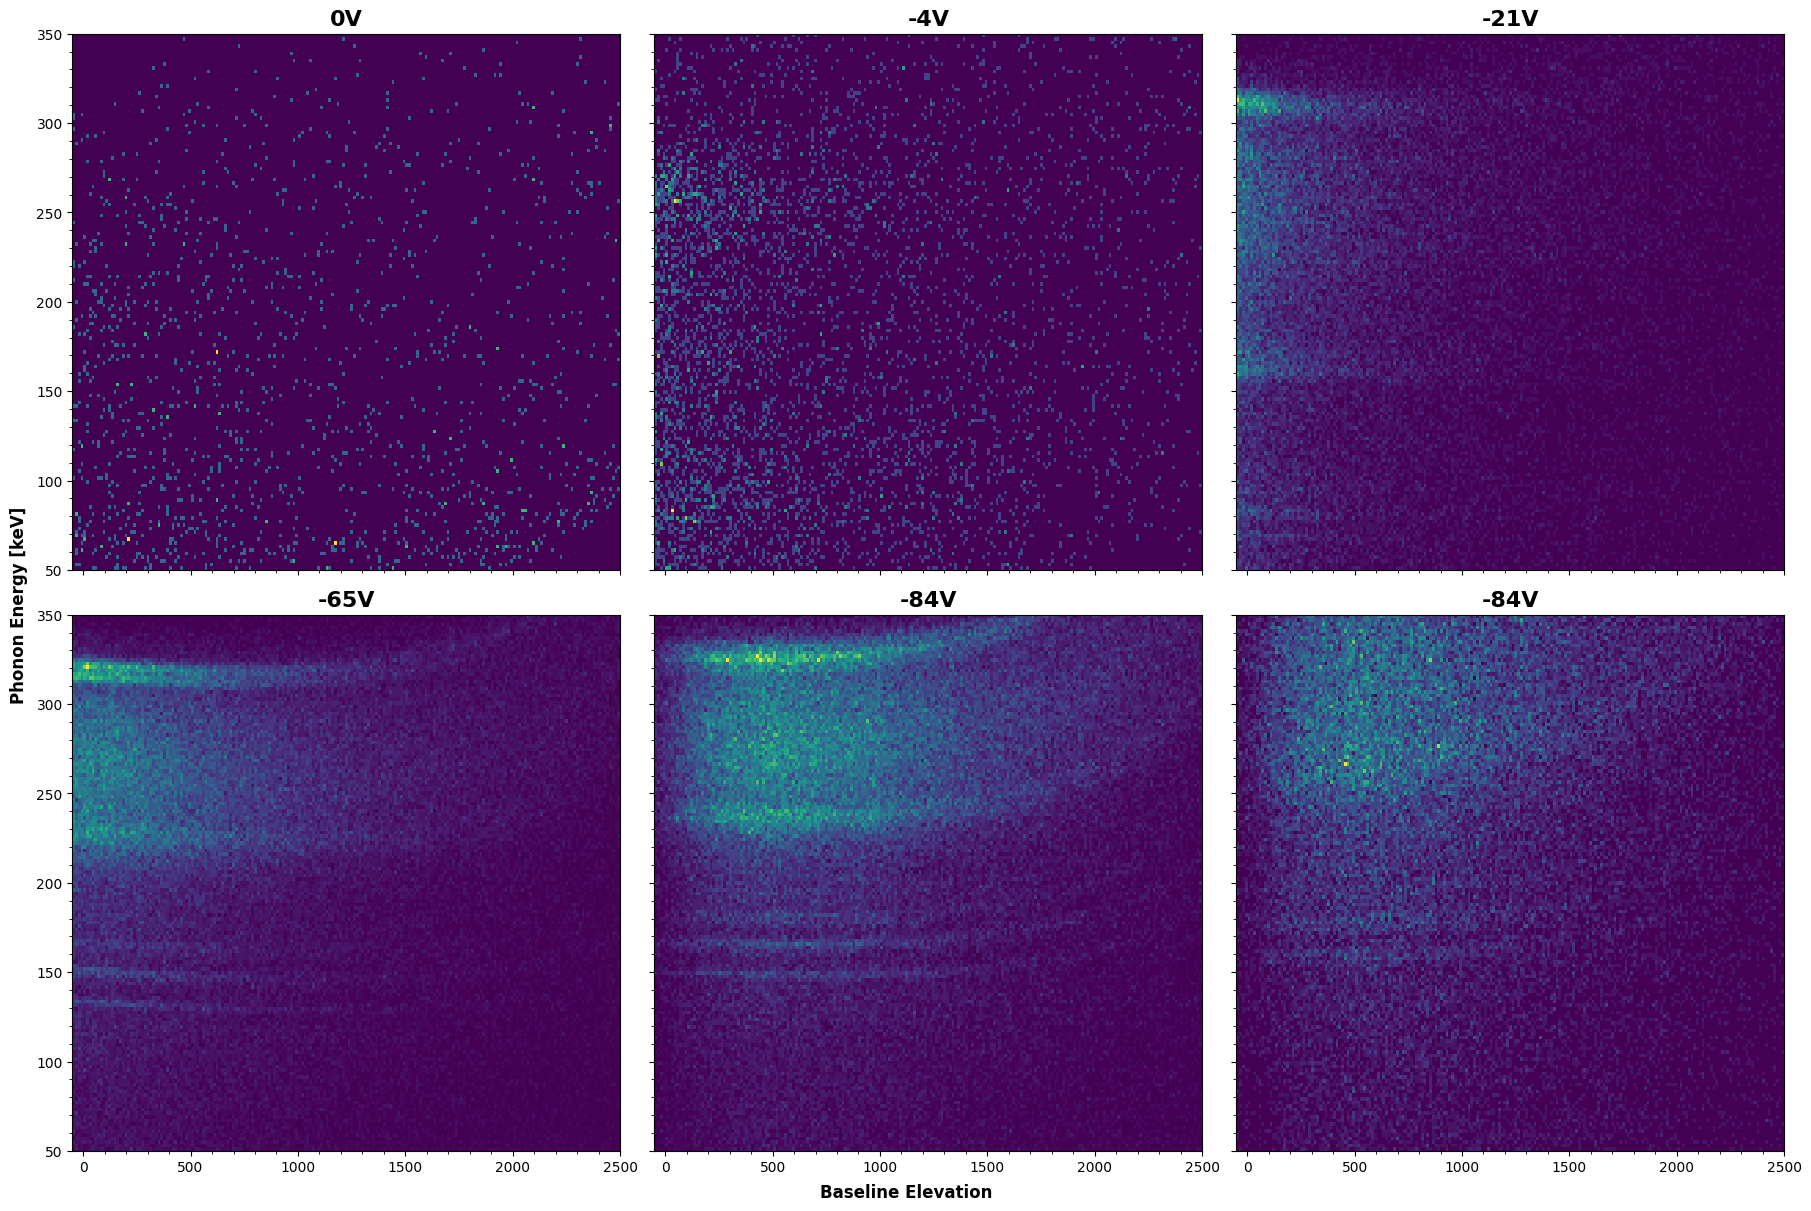

In [5]:
fig,ax = plt.subplots(2,3,figsize=(18,12),sharey=True,sharex=True)

bins = [np.linspace(-50,2500,200),np.linspace(50,350,150)]
G = fit.best_values['m']/fitg.best_values['mu']
for x in z:
    x['bscorr_gau'] = x['pt_keV']/(1.+(x['PSUMbs']-18000.)*G)
    
#Plot
for i,axis in enumerate(ax):
    for j,axis in enumerate(axis):
        axis.set_title(lab[i*3+j])
        x = z[i*3+j]
        axis.hist2d(x['PSUMbs'][~x['crand']]-18000,x['bscorr_gau'][~x['crand']],bins=bins)

fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

We took the correction from the bottom center plot. It may translate to other datasets; the -21V looks okay, although it doesn't show much beyond baseline elevation 500. The 65V data seems mostly okay, and the other set of 84V data seems off but this is most likely due to there being a gap of a few days. The 0V and -4V data aren't readable. Let's check if they're readable before the adjustment:

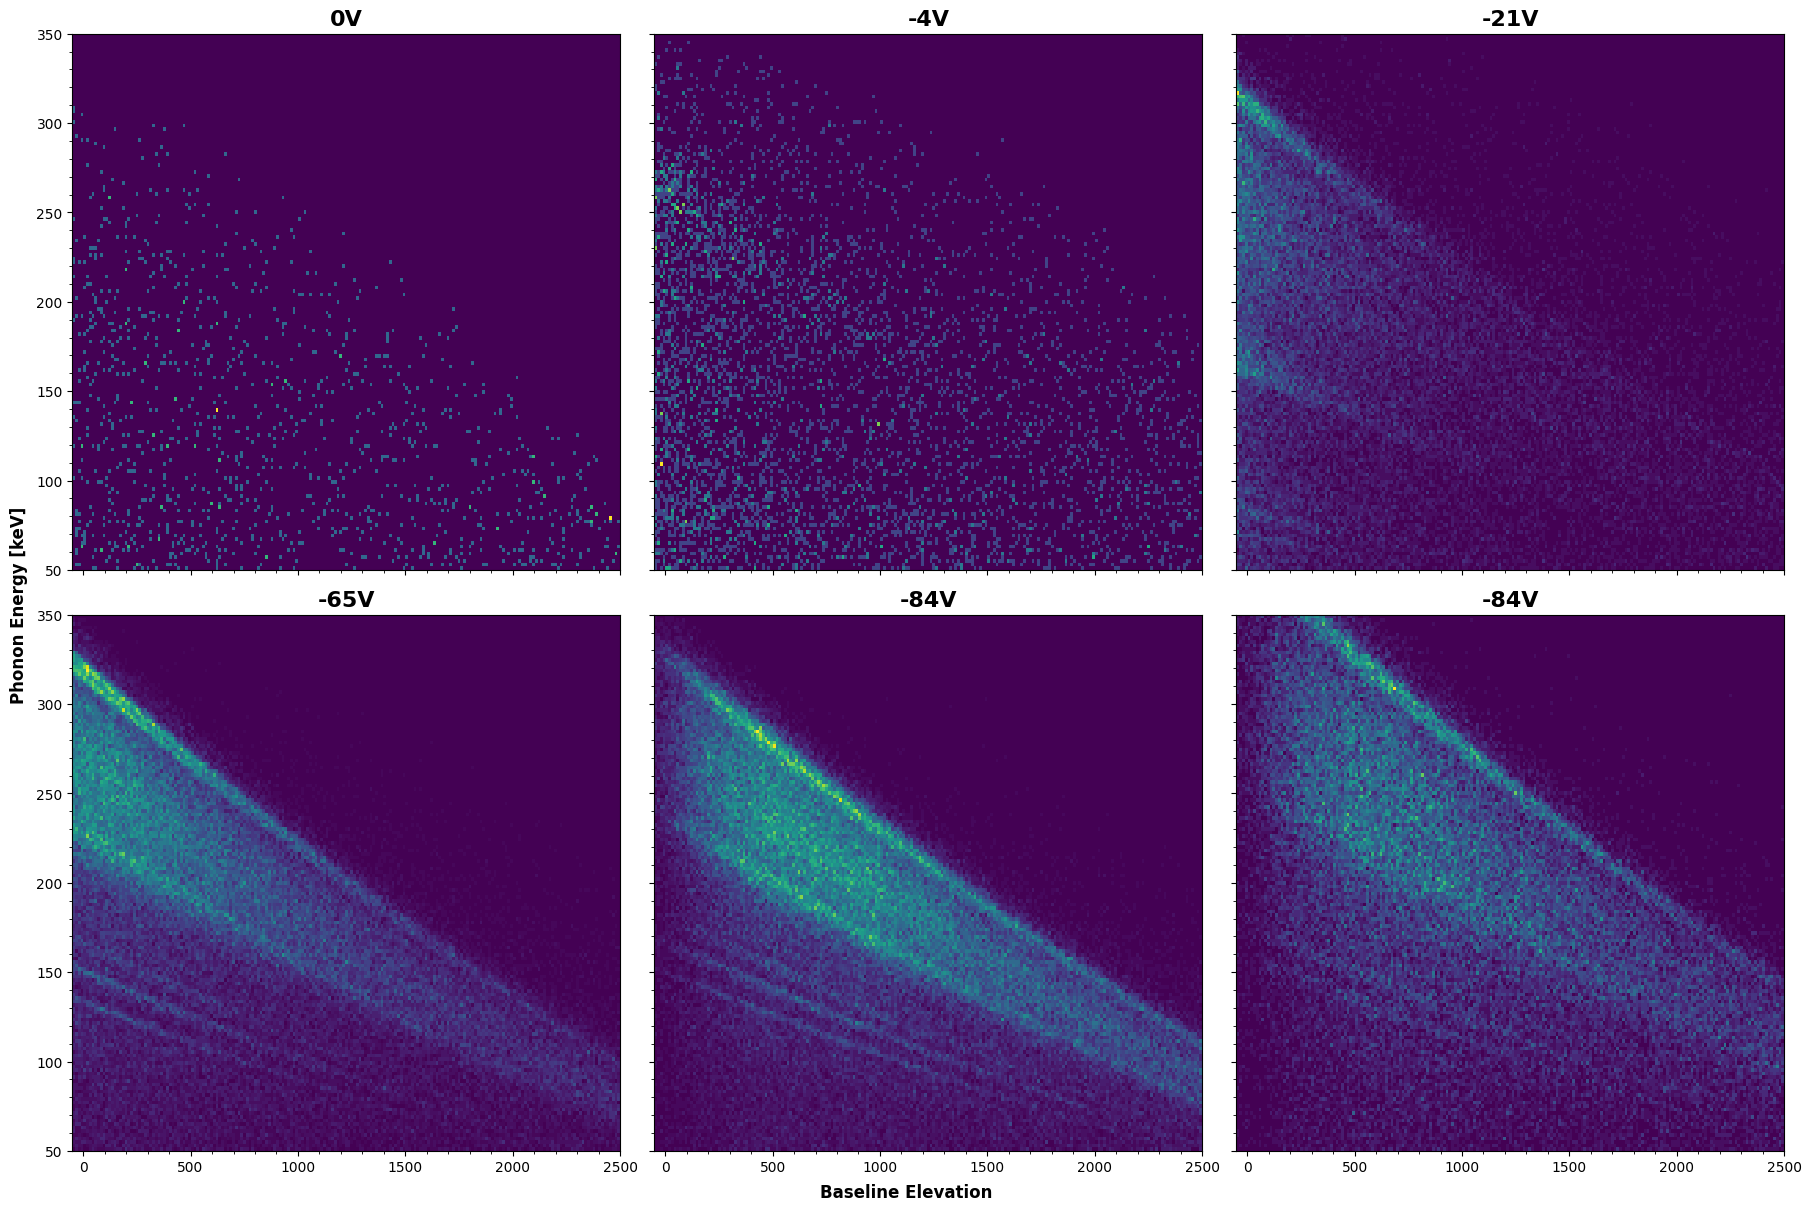

In [6]:
fig,ax = plt.subplots(2,3,figsize=(18,12),sharey=True,sharex=True)

bins = [np.linspace(-50,2500,200),np.linspace(50,350,150)]
G = fit.best_values['m']/fitg.best_values['mu']
for x in z:
    x['bscorr_gau'] = x['pt_keV']/(1.+(x['PSUMbs']-18000.)*G)
    
#Plot
for i,axis in enumerate(ax):
    for j,axis in enumerate(axis):
        axis.set_title(lab[i*3+j])
        x = z[i*3+j]
        axis.hist2d(x['PSUMbs'][~x['crand']]-18000,x['pt_keV'][~x['crand']],bins=bins)

fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

So, yes, it seems the issue is more with the data itself than the corection. Therefore, we will further evaluate mismatched voltages later if necessary after analyzing the date cutoff.

In [7]:
#Import a new dataset across two days
ser = ["07220910_1210","07220910_1517"]
#vlt = 197.3*np.ones(len(ser)) #not presently in use, so stop adjusting it
#vlt = list(vlt) #in case it is an array.

e=[]; z=[];
for series in ser:
    filelist = glob.glob(datapath+series+"/umn*.root")
    e_chain,z_chain = makechain(filelist,fittingfilters)
    e.append(e_chain);z.append(z_chain)

for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)

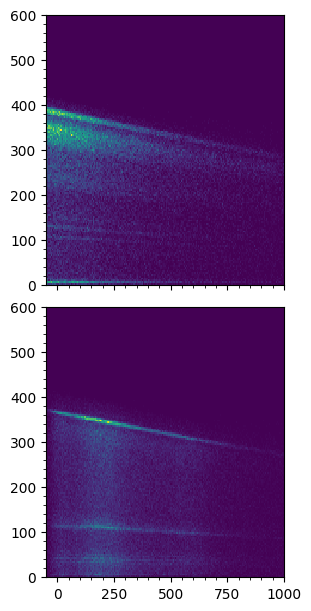

In [8]:
#Create and populate square of plots
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
fig,ax = plt.subplots(vert,hor,figsize=(3*hor,3*vert),sharey=True,sharex=True)
for i,ax in enumerate(ax):
    k = i
    if k < len(z): #do nothing if we have an empty corner.
        ax.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']]
                    ,bins=[np.linspace(-50,1000,200),np.linspace(0,600,150)]) #prebinning isn't seeming to work well

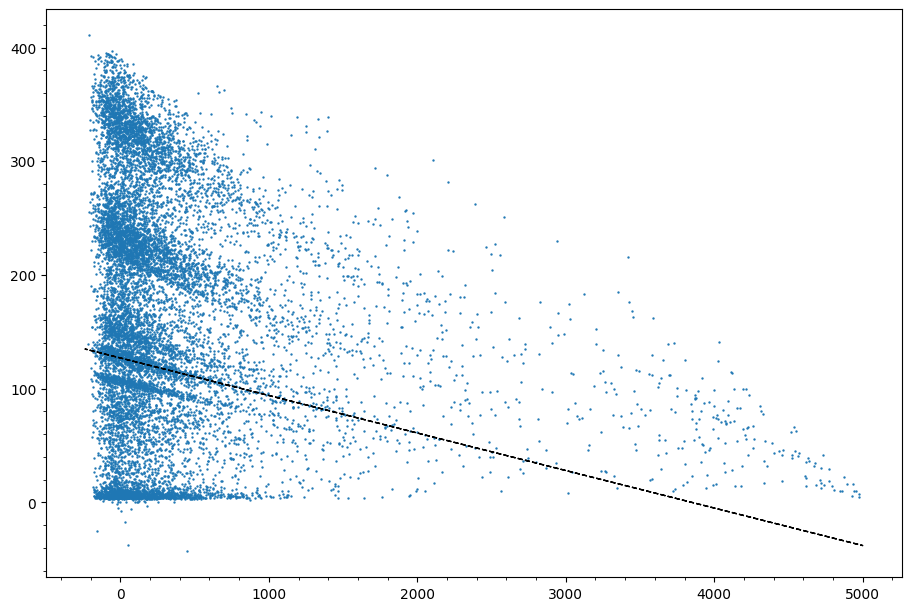

In [9]:
#Take a look at this data
x = z[0]['PSUMbs'][~z[0]['crand']]-18000
y = z[0]['pt_keV'][~z[0]['crand']]

#plt.scatter(x,y,s=0.1) #copypaste back in: & z[f]['cphi1']plt.show()
plt.scatter(z[0]['PSUMbs'][~z[0]['crand'] & z[0]['cphi1']]-18000,
            z[0]['pt_keV'][~z[0]['crand'] & z[0]['cphi1']],s=0.5)
m = -0.033; b = 127
plt.plot(x,line(x,m,b),color='k')
plt.show()

-0.0002598425196850394


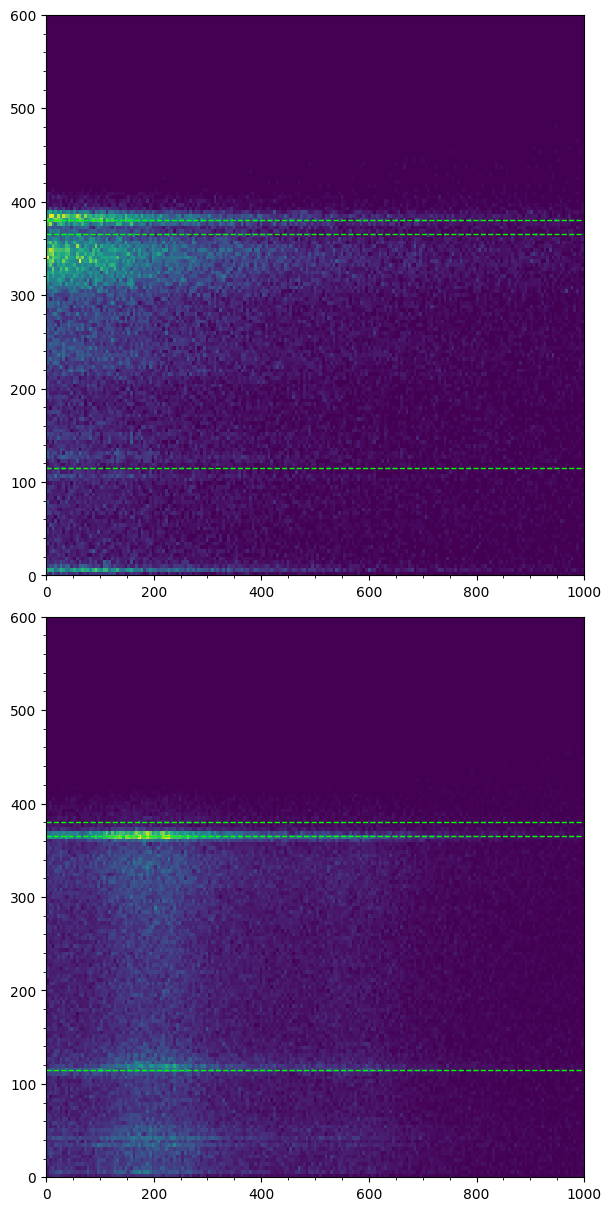

In [10]:
print(m/b)
G = m/b
for x in z:
    x['bscorr_man'] = x['pt_keV']/(1.+(x['PSUMbs']-18000.)*G)
    
x = np.linspace(0,2000)
fig,ax = plt.subplots(vert,hor,figsize=(6*hor,6*vert),sharey=True)
for i,axis in enumerate(ax):
    k = i
    if k < len(z): #do nothing if we have an empty corner.
        axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],
                    bins=[np.linspace(0,1000,200),np.linspace(0,600,150)]) #prebinning isn't seeming to work well
        axis.plot(x,line(x,0,380),color='lime')
        axis.plot(x,line(x,0,365),color='lime')
        axis.plot(x,line(x,0,115),color='lime')
plt.show()

There appears to be some bowing happening in the lowest line in the second plot. While it may be safe to combine data of different voltages, we will avoid this as a safety measure.

## Keeping Across Time
From the above plots, it seems like data from the same day is most likely okay to keep the same correction, but we start to see noticeable errors after three days. We will now look at the first dataset that spans two days to see when the disparity becomes apparent.

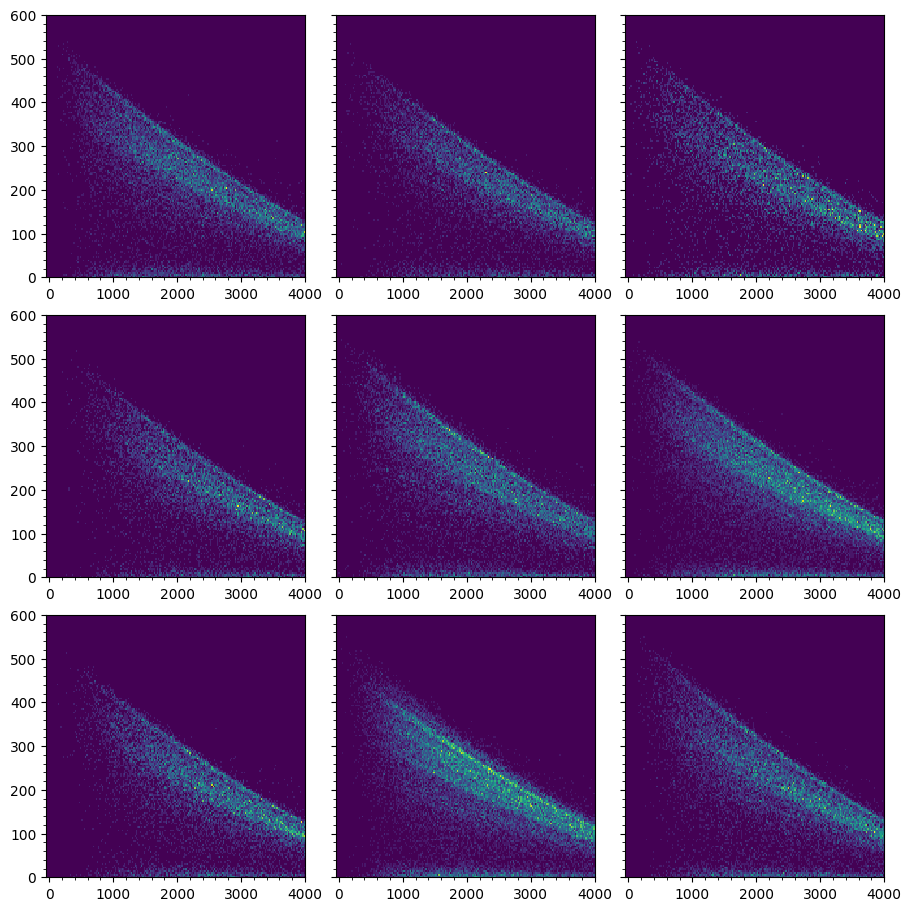

In [11]:
#Import a new dataset across two days
ser = ["07220706_1254","07220706_1652","07220706_2041","07220707_0632","07220707_1748","07220707_2149","07220708_0826","07220708_1618","07220708_2207"]
#vlt = 197.3*np.ones(len(ser)) #not presently in use, so stop adjusting it
#vlt = list(vlt) #in case it is an array.

e=[]; z=[];
for series in ser:
    filelist = glob.glob(datapath+series+"/umn*.root")
    e_chain,z_chain = makechain(filelist,fittingfilters)
    e.append(e_chain);z.append(z_chain)

for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)

#Create and populate square of plots
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
fig,ax = plt.subplots(vert,hor,figsize=(3*vert,3*hor),sharey=True)
for i,axarray in enumerate(ax):
    for j,axis in enumerate(axarray):
        k = j + i*len(axarray)
        if k < len(z): #do nothing if we have an empty corner.
            axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']],
                        bins=[np.linspace(-50,4000,200),np.linspace(0,600,150)]) #prebinning isn't seeming to work well

Let's try a manual correction on one of the datasets from the 7th:

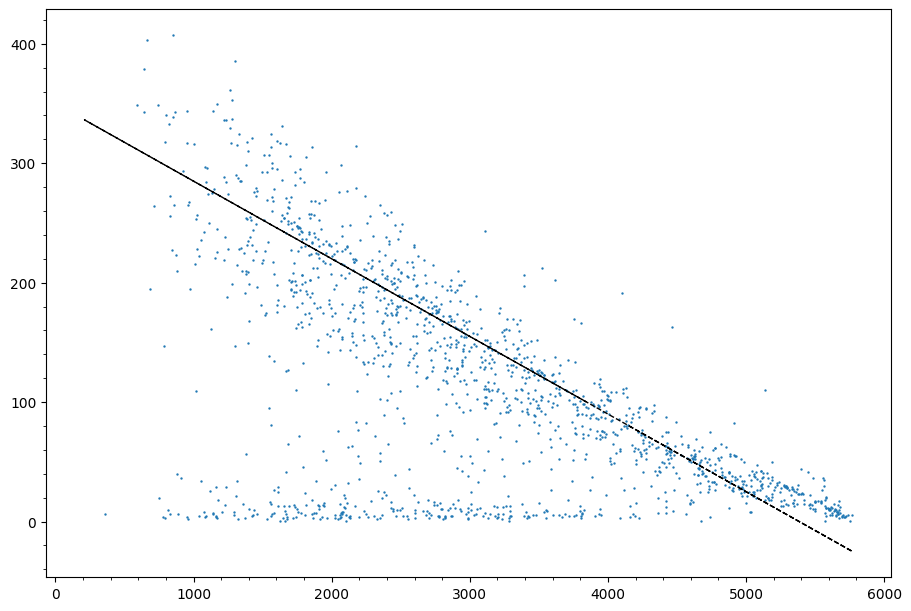

In [12]:
#Take a look at this data
x = z[3]['PSUMbs'][~z[3]['crand']]-18000
y = z[3]['pt_keV'][~z[3]['crand']]

#plt.scatter(x,y,s=0.1) #copypaste back in: & z[f]['cphi1']plt.show()
plt.scatter(z[3]['PSUMbs'][~z[3]['crand'] & z[3]['cphi1']]-18000,
            z[3]['pt_keV'][~z[3]['crand'] & z[3]['cphi1']],s=0.5)
m = -0.065; b = 350
plt.plot(x,line(x,m,b),color='k')
plt.show()

There weren't clear Americium lines with any cut I tried, so we'll adjust the correction factor manually from here:

-0.00018571428571428572


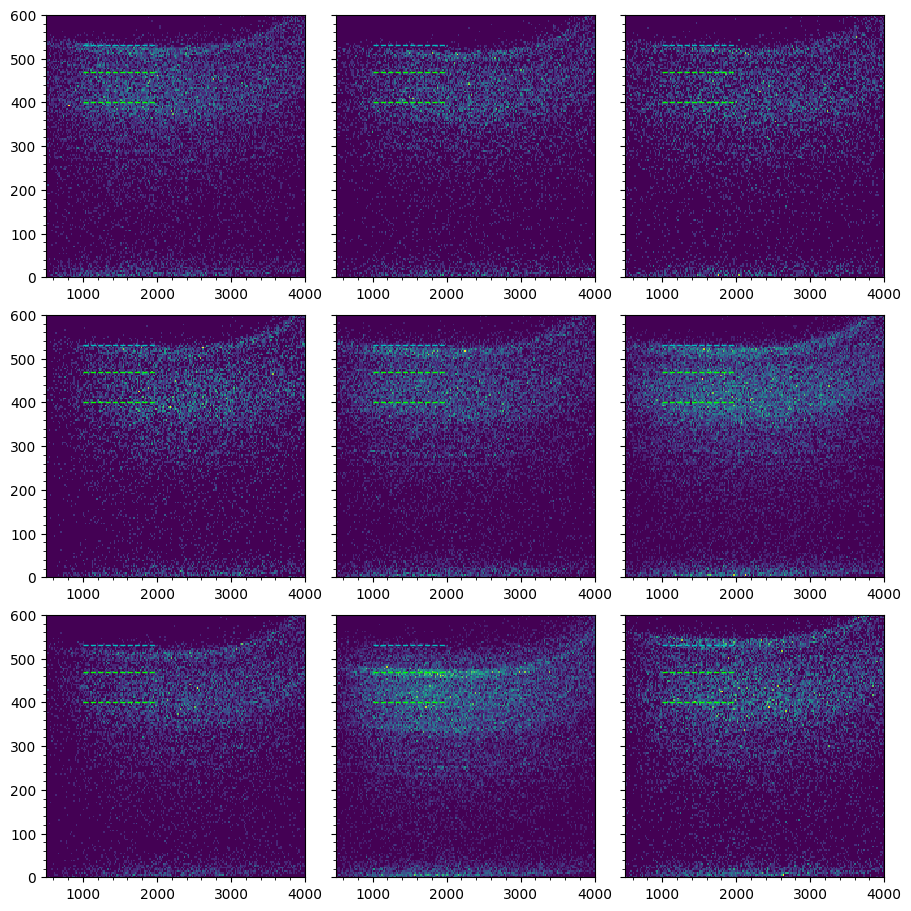

In [13]:
print(m/b)
G = -0.0002
for x in z:
    x['bscorr_man'] = x['pt_keV']/(1.+(x['PSUMbs']-18000.)*G)
    
x = np.linspace(1000,2000)
fig,ax = plt.subplots(vert,hor,figsize=(3*vert,3*hor),sharey=True)
for i,axarray in enumerate(ax):
    for j,axis in enumerate(axarray):
        k = j + i*len(axarray)
        if k < len(z): #do nothing if we have an empty corner.
            axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],
                        bins=[np.linspace(500,4000,200),np.linspace(0,600,150)]) #prebinning isn't seeming to work well
            axis.plot(x,line(x,0,530),color='c')
            axis.plot(x,line(x,0,470),color='lime')
            axis.plot(x,line(x,0,400),color='lime')
plt.show()

-0.00018571428571428572


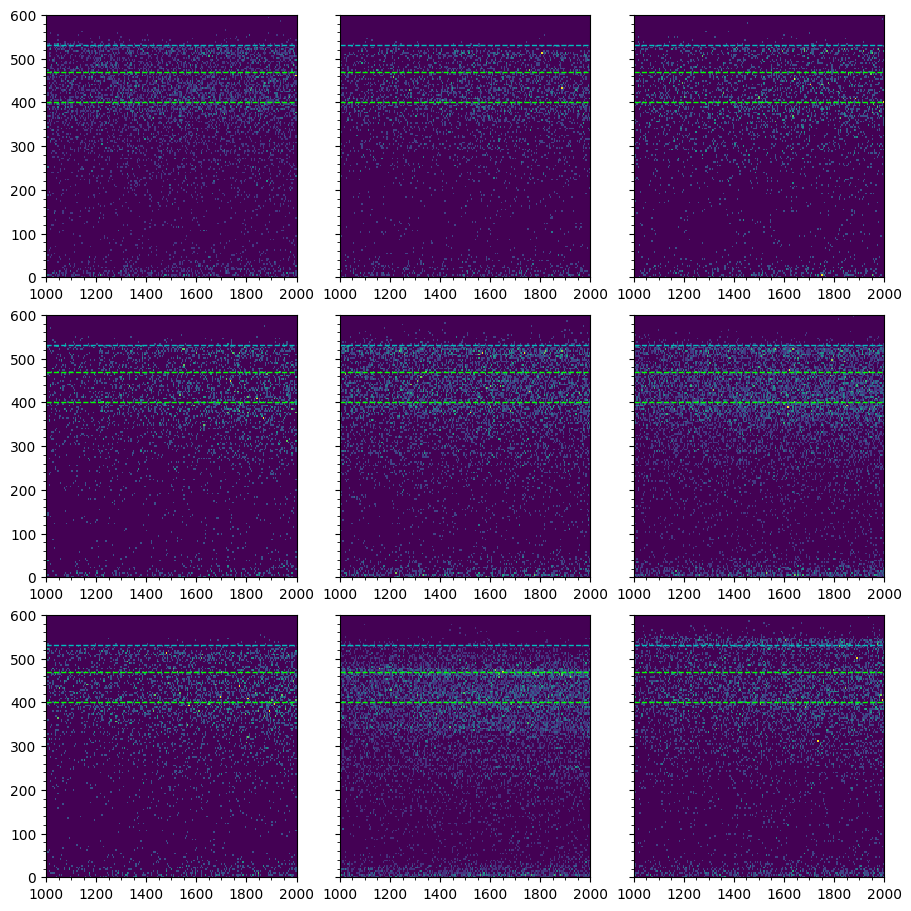

In [14]:
print(m/b)
G = -0.0002
for x in z:
    x['bscorr_man'] = x['pt_keV']/(1.+(x['PSUMbs']-18000.)*G)
    
x = np.linspace(1000,2000)
fig,ax = plt.subplots(vert,hor,figsize=(3*vert,3*hor),sharey=True)
for i,axarray in enumerate(ax):
    for j,axis in enumerate(axarray):
        k = j + i*len(axarray)
        if k < len(z): #do nothing if we have an empty corner.
            axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],
                        bins=[np.linspace(1000,2000,200),np.linspace(0,600,150)]) #prebinning isn't seeming to work well
            axis.plot(x,line(x,0,530),color='c')
            axis.plot(x,line(x,0,470),color='lime')
            axis.plot(x,line(x,0,400),color='lime')
plt.show()

**Three days appears to be a safe cutoff for a small region of interest (1k-2k). Beyond that, 1 day is a safer cutoff. We use 1 day for best results.**

### The below section is temporarily commented out. The peak detection algorithm is not as robust as previously thought and therefore will need to be adjusted or discarded.

## Long Datasets

Some of our datasets run for multiple hours and may have drift within the file. Below, we will experiment with the need to split them.

In [15]:
#Start by importing and organizing our data
ser = ["07221001_2314"]

e=[]; z=[];
for series in ser:
    filelist = glob.glob(datapath+series+"/umn*0.root") #load a tenth of the data, interspersed, to load faster
    e_chain,z_chain = makechain(filelist,fittingfilters+["EventTime"])
    e.append(e_chain);z.append(z_chain)

for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)

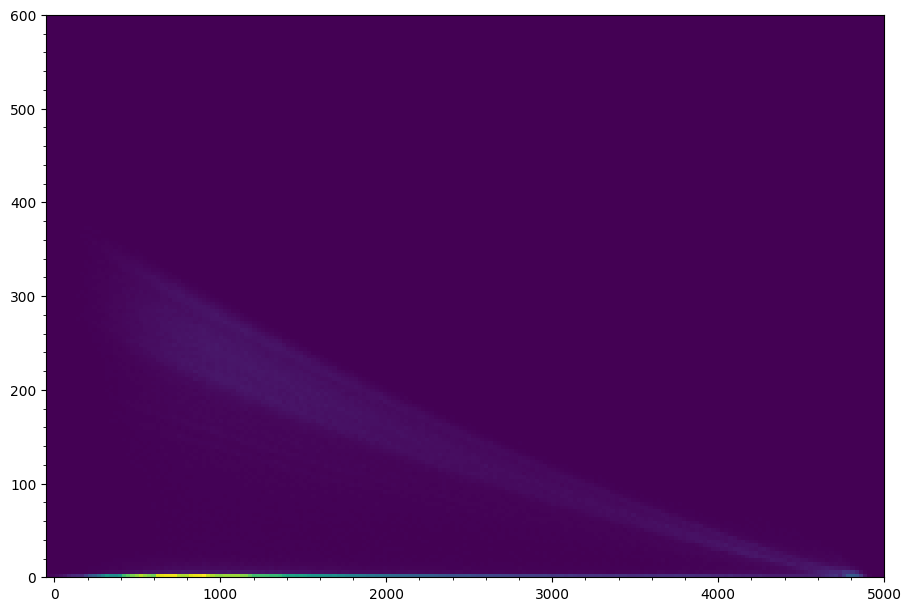

In [16]:
#Create and populate square of plots
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
#fig,ax = plt.subplots(vert,hor,figsize=(3*hor,3*vert),sharey=True,sharex=True)
k = 0
plt.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']]
                    ,bins=[np.linspace(-50,5000,200),np.linspace(0,600,150)]) #prebinning isn't seeming to work well
plt.show()

No obvious issues here. Let's look at a time plot:

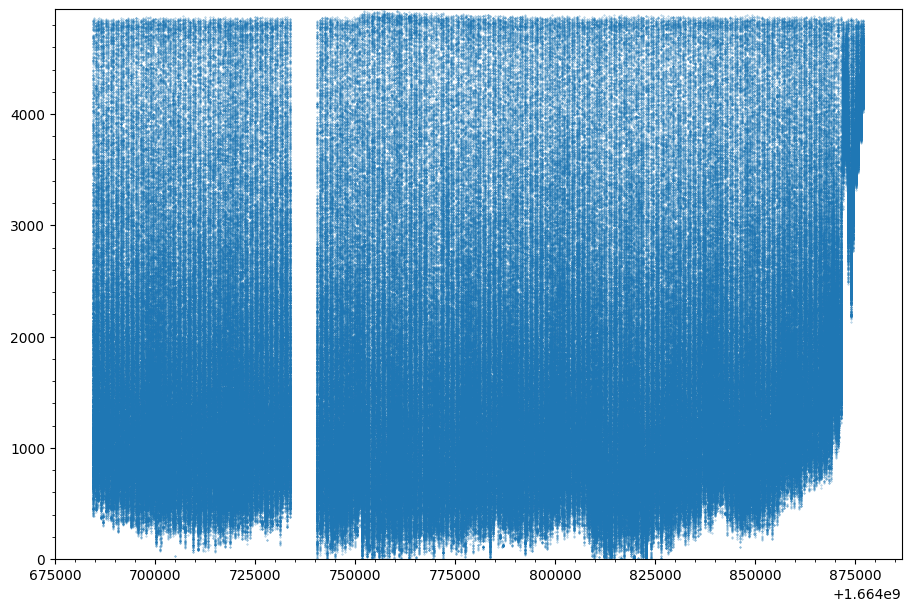

In [17]:
plt.scatter(z[k]['EventTime'][~z[k]['crand']],z[k]['PSUMbs'][~z[k]['crand']]-18000,s=0.1,alpha=0.6)
plt.ylim(0,max(z[k]['PSUMbs'][~z[k]['crand']]-18000))
plt.show()

There's a gap to watch for, though it's not clear why... we're loading every tenth file, so the striations make sense but the singular gap does not. However, what's important is that there are some shifts within the data, so we need to split this one by time when we do the baseline correction for it.

# Checking specific datasets

In [26]:
import re

ser = ["07221112_0943"]
neogpath = "/data/chocula/neog/rq/"

e=[]; z=[];
for series in ser:
    filelist = sorted(glob.glob(datapath+series+"/umn*.root")) #load a tenth of the data, interspersed, to load faster
    regex = re.compile(r'.+[[0-1,6]1,34,100]\.root'); filelist = [i for i in filelist if not regex.search(i)]
    regex = re.compile(r'.+[34,100]\.root'); filelist = [i for i in filelist if not regex.search(i)]
    e_chain,z_chain = makechain(filelist,fittingfilters+["EventTime"])
    e.append(e_chain);z.append(z_chain)

for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)

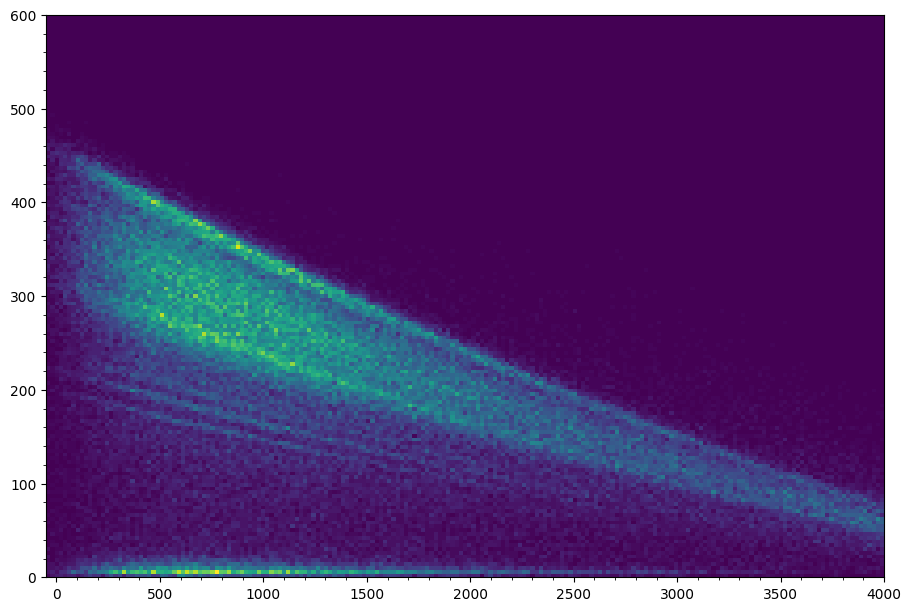

In [23]:
#Create and populate square of plots
k = 0
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
plt.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']],
                        bins=[np.linspace(-50,4000,200),np.linspace(0,600,150)]) #prebinning isn't seeming to work well
plt.show()

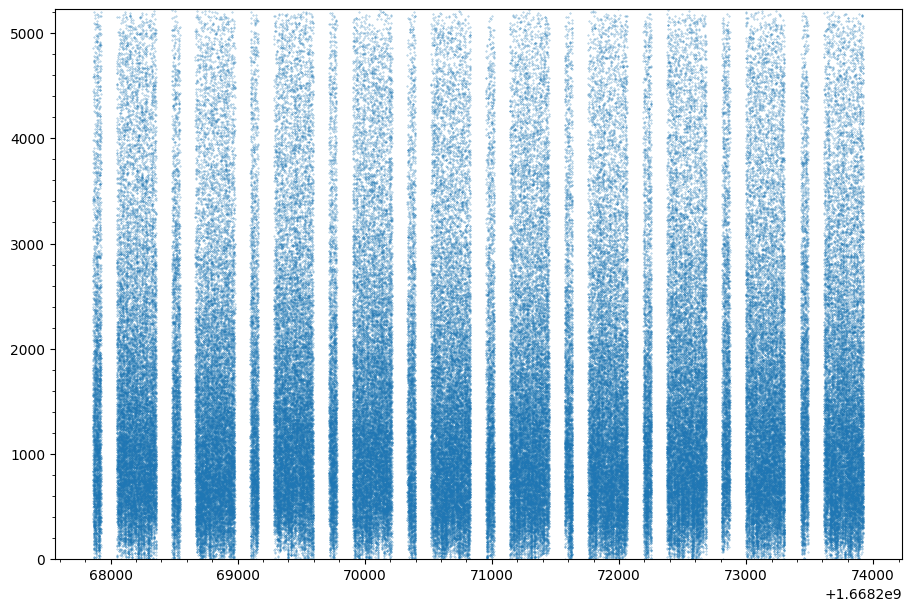

In [24]:
k = 0
plt.scatter(z[k]['EventTime'][~z[k]['crand']],z[k]['PSUMbs'][~z[k]['crand']]-18000,s=0.1,alpha=0.6)
plt.ylim(0,max(z[k]['PSUMbs'][~z[k]['crand']]-18000))
plt.show()

## Current proposed groupings:  

Format: `firstconsecutive:lastconsecutive:skipXbeforetakingnext(default 0);anotherseries` (length)

1. `07220609_1114` (1)
2. `07220615_1205` (1)

~~`07220703_2005,07220703_2143` (2)~~ says HV leakage and the data looks weird (empty sections at beginning). so not sure if this is good data, skipping for now but making a note.

4. `07220706_1254:07220706_0632:1` (3)
5. `07220707_1748:07220707_2149:1` (3)
6. `07220708_0826;07220708_1618;07220708_2207` (3)
7. `07220709_0926;07220709_1415` (2)
8. `07220711_1649:07220711_1709` (2)
9. `07220822_1818:07220827_1153`\* (5) - subset of data from `AutoHV1Summary.ipynb`.
10. `07220830_1724;07220830_0955` (2)
11. `07220831_0955;07220831_1002;07220831_1846` (3)
13. `07220909_2023` (1)
14. `07220910_1210` (1)
15. `07220910_1517` (1)
16. `07220912_1955` (1)
17. `07220913_0814` (1)
18. `07220913_1457` (1)
19. `07220914_1133` (1)
20. `07220916_2059` (1)
21. `07220917_1039;07220917_2125` (2)
22. `07220919_1723` (1)
23. `07220920_0925;07220920_2052` (2)
24. `07220921_0915;07220921_1541;07220921_2055` (3)

--- NOT COMPLETE ON WIKI YET; Also corresponds roughly to He issues. ---

25. `07221001_2314` Needs to be split by timestamp for baseline correction.
26. `07221017_1600` Needs to be split by timestamp for baseline correction.
27. `07221019_1741:077221019_2240:1`
28. `07221020_0849:077221020_1948:1` first NaI set crosses 10 a.m. but is very close to start; seems ok, hard to tell for NaI data. third has note that there are empty dumps but the first part should be good.
29. `07221021_1001`
30. `07221022_1630`
31. `07221023_1051`
32. `07221025_1751`
33. `07221026_0951:07221026_2224:1` 10 a.m. but seems ok
34. `07221027_0915` cuts close to 10 a.m., no sudden jumps but baseline looks a little odd, keep an eye out
35. `07221111_2153`
36. `07221112_0943:07221112_2249:1` first is still being reprocessed but seems ok. The files removed were: `.+[[0-1,6]1,34,100]\.root`, `.+[34,100]\.root`
37. `07221113_1159`
37. `07221114_2141:07221115_0845`
38. `07221115_2109`
39. `07221116_1003`
40. `07221118_1404:07221118_1850`
41. `07221119_1016`
42. `07221121_2214`
43. `07221124_1408`
44. `07221124_1603`
45. `07221124_1748`
46. `07221124_2022:07221124_2331`
47. `07221203_1255`
48. `07221203_1418`
49. `07221203_1622`
50. `07221203_1744`
51. `07221203_1906`
52. `07221203_2025`

In addition to any crossed-out entries above, I have skipped entries meeting any of the following criteria:
* Has a note stating that the data is bad.
* No location for series files listed.
* No PuBe source.
* HV column lists that voltage bias was set to 0 - doesn't need correction.
* Trigger was NaI - coincidence.